In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


Importar el archivo Raw del csv almacenado en Github

In [2]:
url = 'https://raw.githubusercontent.com/DanielRojasSidink/logistic-regression/main/Bancarrota.finalll.csv'
pgf = pd.read_csv(url)
data= pgf.dropna()
print(data)
print(list(data.columns))

     Data Year - Fiscal  Tobin's Q     EPS  Liquidity  Profitability  \
0                  2007      6.650  -0.360     -1.350        -20.950   
1                  2009      0.825  -4.834      0.245         -1.853   
2                  2008      5.020  -0.056      0.041        -14.427   
3                  2008      0.823  -0.375      0.073         -1.658   
4                  2008      2.664 -10.544     -0.416         -1.776   
..                  ...        ...     ...        ...            ...   
190                2012      1.676  -5.622     -1.315         -1.358   
191                2007      1.460   0.010     -0.400        -21.900   
192                2007      1.114  -0.337     -0.143         -0.353   
193                2007      0.930  -8.530      0.000         -0.070   
194                2008      1.510  -0.043      0.252         -8.346   

     Productivity  Leverage Ratio  Asset Turnover  Operational Margin  \
0          -0.160          -1.160           0.630             

Analisis exploratorio inicial de la Data, esto para ver si hay que realizar alguna limpieza.

In [3]:
# estadística descriptiva
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 191 entries, 0 to 194
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Data Year - Fiscal  191 non-null    int64  
 1   Tobin's Q           191 non-null    float64
 2   EPS                 191 non-null    float64
 3   Liquidity           191 non-null    float64
 4   Profitability       191 non-null    float64
 5   Productivity        191 non-null    float64
 6   Leverage Ratio      191 non-null    float64
 7   Asset Turnover      191 non-null    float64
 8   Operational Margin  191 non-null    float64
 9   Return on Equity    191 non-null    float64
 10  Market Book Ratio   191 non-null    float64
 11  Assets Growth       191 non-null    float64
 12  Sales Growth        191 non-null    float64
 13  Employee Growth     191 non-null    float64
 14  BK                  191 non-null    int64  
dtypes: float64(13), int64(2)
memory usage: 23.9 KB
None
       Dat

Generar Histogramas de las columnas que se requieran para la fase exploratoria.

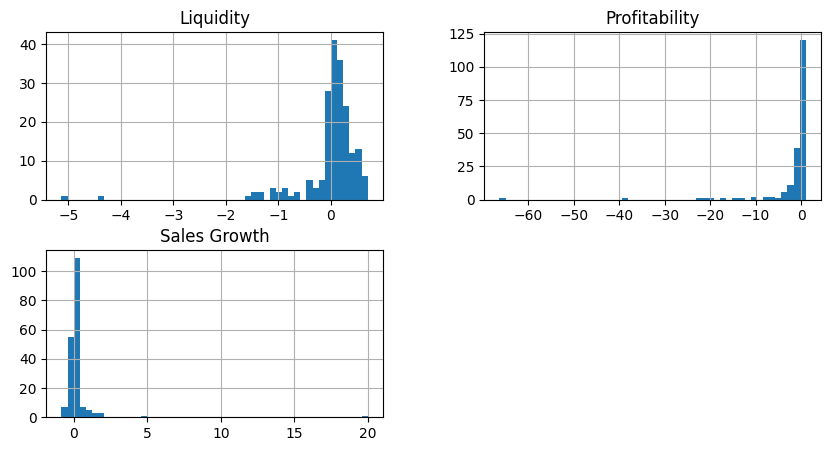

In [4]:
columnas_a_graficar = ['Liquidity', 'Profitability', 'Sales Growth'] 
data[columnas_a_graficar].hist(bins=50, figsize=(10, 5))
plt.show()

Analisis de correlación

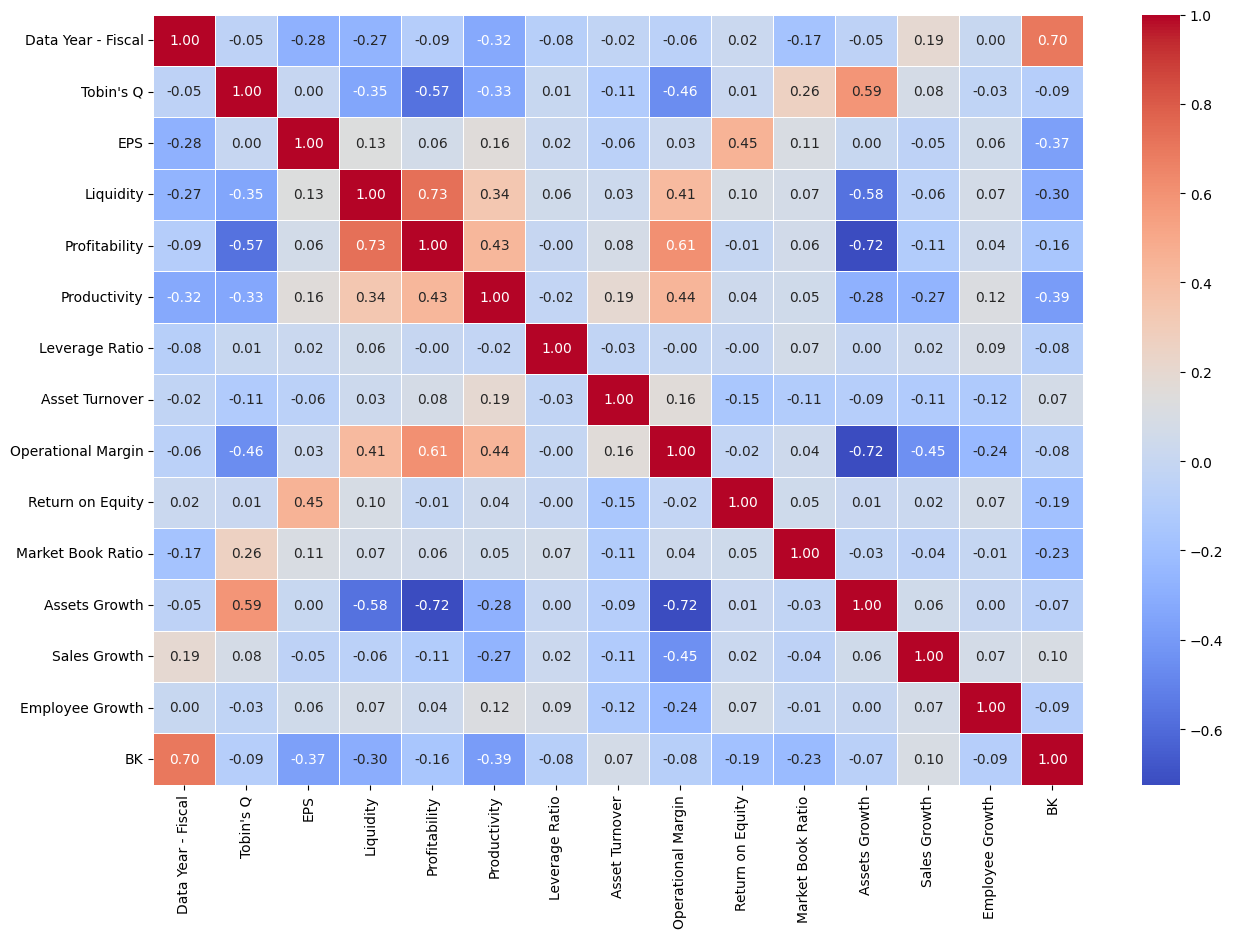

In [5]:
correlation_matrix = data.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True,  fmt=".2f", cmap='coolwarm', linewidths=.5)
plt.show()

Análisis de multicolinealidad ( factor de inflación de la varianza, VIF >5 o > 10 indican fuerte correlación entre variables independientes

In [6]:
data_with_constant = add_constant(data.drop(['Data Year - Fiscal', 'BK'], axis=1))
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(data_with_constant.values, i) for i in range(data_with_constant.shape[1])]
vif["features"] = data_with_constant.columns
print(vif.round(2))

    VIF Factor            features
0         3.26               const
1         2.03           Tobin's Q
2         1.31                 EPS
3         2.37           Liquidity
4         3.67       Profitability
5         1.60        Productivity
6         1.03      Leverage Ratio
7         1.11      Asset Turnover
8         4.42  Operational Margin
9         1.30    Return on Equity
10        1.21   Market Book Ratio
11        4.23       Assets Growth
12        1.61        Sales Growth
13        1.31     Employee Growth


Agrupación por la media de las vairables independietnes respecto a la variable dependiente Bancarrota

Infrmación global por categoria:porcentaje de variables independiente según su categoría

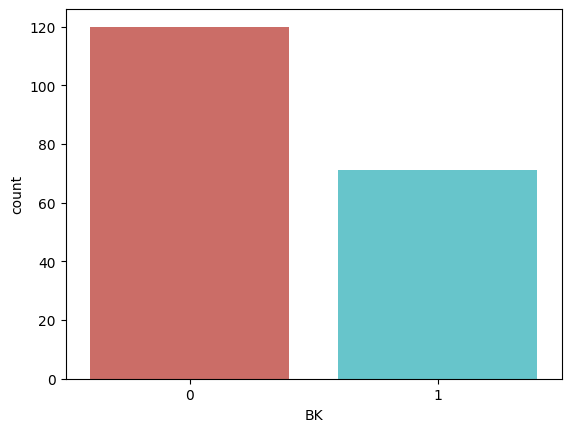

percentage of healthy bank 63.0
percentage of bankruptcy 37.0


<Figure size 640x480 with 0 Axes>

In [7]:
sns.countplot(x='BK', hue='BK', data=data, palette='hls', legend=False)
plt.show()
plt.savefig('count_plot')
count_no_sub = len(data[data['BK']==0])
count_sub = len(data[data['BK']==1])
pct_of_no_sub = count_no_sub/(count_no_sub+count_sub)
print("percentage of healthy bank", round(pct_of_no_sub*100, 0))
pct_of_sub = count_sub/(count_no_sub+count_sub)
print("percentage of bankruptcy", round(pct_of_sub*100, 0))


Segmentación por Variable dependiente refeljando la media de las Variables independientes 

In [8]:
data.groupby('BK').mean()

,Data Year - Fiscal,Tobin's Q,EPS,Liquidity,Profitability,Productivity,Leverage Ratio,Asset Turnover,Operational Margin,Return on Equity,Market Book Ratio,Assets Growth,Sales Growth,Employee Growth
BK,,,,,,,,,,,,,,
0,2007.0,2.545333,1.884333,0.145250,-0.836250,0.069583,0.647833,1.103917,-0.863417,0.012333,1201.467333,1.571833,0.131683,0.059908
1,2010.0,1.772423,-2.652958,-0.257085,-2.940634,-0.254437,-3.371113,1.250690,-2.685085,-44.089324,52.931451,-0.142563,0.445592,0.004056


Realizar las transformaciones correspondientes según tipo de VI (Nominal, Ordinal). Asinarlas como VI y VD, excluyendo a las que se consideraron omitir en el modelo. La Estandarización se realiza en la siguiente celula.

In [9]:
# Omitimos la primera columna (años) y tomar las siguientes 13 columnas como variables independientes
X = data.iloc[:, 1:14] 
# 'BK' es la variable dependiente 
y = data['BK']
print(X)
print (y)

     Tobin's Q     EPS  Liquidity  Profitability  Productivity  \
0        6.650  -0.360     -1.350        -20.950        -0.160   
1        0.825  -4.834      0.245         -1.853        -0.089   
2        5.020  -0.056      0.041        -14.427        -2.367   
3        0.823  -0.375      0.073         -1.658        -0.209   
4        2.664 -10.544     -0.416         -1.776         0.178   
..         ...     ...        ...            ...           ...   
190      1.676  -5.622     -1.315         -1.358         0.027   
191      1.460   0.010     -0.400        -21.900         0.050   
192      1.114  -0.337     -0.143         -0.353        -0.054   
193      0.930  -8.530      0.000         -0.070        -0.040   
194      1.510  -0.043      0.252         -8.346        -0.601   

     Leverage Ratio  Asset Turnover  Operational Margin  Return on Equity  \
0            -1.160           0.630              -0.260            -0.650   
1             1.644           0.510              -0.1

Entrenamiento del modelo

In [12]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo de regresión logística aca dentro de los () de LogisticRegression()  se puede seleccionar el metodo de optimización de los coeficientes que se considere más apropiado.
model = LogisticRegression()
  #model = LogisticRegression(solver='newton-cg', penalty='l2', multi_class='multinomial')
  #model = LogisticRegression(solver='saga', penalty='elasticnet', l1_ratio=0.5, multi_class='multinomial', max_iter=10000)
model.fit(X_train_scaled, y_train)

# Realizar predicciones sobre el conjunto de prueba
predictions = model.predict(X_test_scaled)

# Evaluar el modelo
accuracy = accuracy_score(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)
class_report = classification_report(y_test, predictions)

# Imprimir los resultados
print("Coeficientes del modelo:", model.coef_)
print("Exactitud del modelo:", accuracy_score(y_test, predictions))
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)



Coeficientes del modelo: [[-0.98424021 -0.35087367 -1.12843981  0.03075206 -1.8937337  -0.13491344
   0.31574289 -0.44274539 -0.82930374 -1.71294753 -0.71904804  0.08165791
   0.36226216]]
Exactitud del modelo: 0.9230769230769231
Confusion Matrix:
[[29  0]
 [ 3  7]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        29
           1       1.00      0.70      0.82        10

    accuracy                           0.92        39
   macro avg       0.95      0.85      0.89        39
weighted avg       0.93      0.92      0.92        39



Generar una Gráfica para la Matriz de Confusión

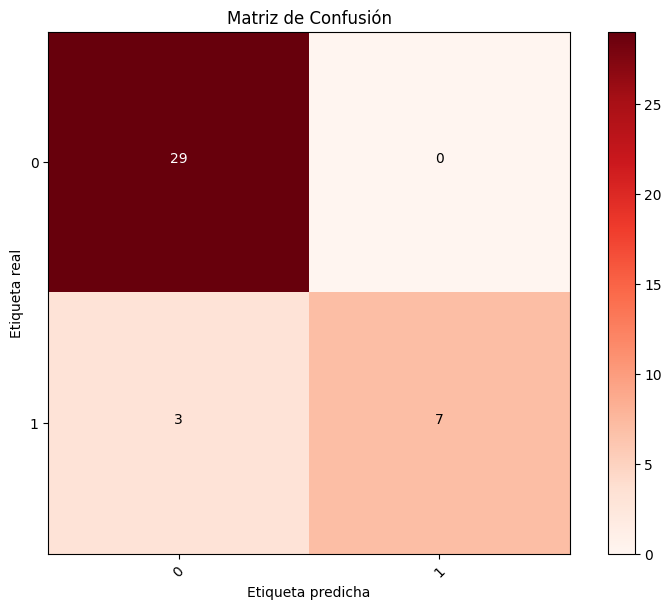

In [11]:
import itertools

conf_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6)) # Ajusta el tamaño de la figura si es necesario
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Reds)
plt.title('Matriz de Confusión')
plt.colorbar()
tick_marks = np.arange(len(set(y_test))) # Asumiendo que y_test es tu lista de etiquetas verdaderas
plt.xticks(tick_marks, set(y_test), rotation=45)
plt.yticks(tick_marks, set(y_test))

# Añadir etiquetas a cada celda
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('Etiqueta real')
plt.xlabel('Etiqueta predicha')
plt.show()

Utilizarlo con Datos ingresados manualmente para ver qué predicción hace:

In [14]:
def predecir_y_obtener_probabilidad(Tobins_Q, EPS, Liquidity, Profitability, Productivity, Leverage_Ratio, Asset_Turnover, Operational_Margin, Return_on_Equity, Market_Book_Ratio, Assets_Growth, Sales_Growth, Employee_Growth):

    input_data = pd.DataFrame({
        "Tobin's Q": [Tobins_Q],
        "EPS": [EPS],
        "Liquidity": [Liquidity],
        "Profitability": [Profitability],
        "Productivity": [Productivity],
        "Leverage Ratio": [Leverage_Ratio],
        "Asset Turnover": [Asset_Turnover],
        "Operational Margin": [Operational_Margin],
        "Return on Equity": [Return_on_Equity],
        "Market Book Ratio": [Market_Book_Ratio],
        "Assets Growth": [Assets_Growth],
        "Sales Growth": [Sales_Growth],
        "Employee Growth": [Employee_Growth]
    }).values  # Convierte el DataFrame a un array de NumPy

    predicted_class = model.predict(input_data)
    predicted_prob = model.predict_proba(input_data)

    print("Clase predicha:", predicted_class[0])
    print("Probabilidad de cada clase:")
    print(predicted_prob[0])

# Introducir manualmente aca los valores para hacer la predicción
predecir_y_obtener_probabilidad(
    Tobins_Q=0.3, 
    EPS=1.9, 
    Liquidity=-0.8, 
    Profitability=-0.5, 
    Productivity=-0.6, 
    Leverage_Ratio=0.7, 
    Asset_Turnover=0.8, 
    Operational_Margin=-0.9, 
    Return_on_Equity=1.0, 
    Market_Book_Ratio=1.1, 
    Assets_Growth=3, 
    Sales_Growth=0, 
    Employee_Growth=1.4
)

Clase predicha: 0
Probabilidad de cada clase:
[0.96086336 0.03913664]
